# HW1. Alignment to reference, variant calling.

In this project, we will work with real sequencing data from a strain of E. coli resistant to the antibiotic ampicillin. Your job is to analyze that sequencing data to locate the mutations responsible for giving E. coli its antibiotic resistance property. You will research the genes that are mutated to identify the mechanism of antibiotic resistance in each case, and you will make recommendations for alternative antibiotics a doctor could use to treat each strain.

## 1. Obtaining data

- reference \
`wget -O data/GCF_000005845.2_ASM584v2_genomic_reference.fna.gz https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.fna.gz` \
`wget -O data/GCF_000005845.2_ASM584v2_genomic_annot.gff.gz https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.gff.gz` 
- raw ilumina reads. 1 - forward, 2 - reverse \
`wget -O data/e_coli_k12_reads_forward.fastq.gz https://figshare.com/ndownloader/files/23769689` \
`gunzip data/e_coli_k12_reads_forward.fastq.gz` \
`wget -O data/e_coli_k12_reads_reverse.fastq.gz https://figshare.com/ndownloader/files/23769692` \
`gunzip data/e_coli_k12_reads_reverse.fastq.gz` 
- to see how many rows \
`wc -l data/e_coli_k12_reads_forward.fastq` \
`wc -l data/e_coli_k12_reads_reverse.fastq`

## 2. FastQC
`fastqc data/e_coli_k12_reads_forward.fastq -o data/` 

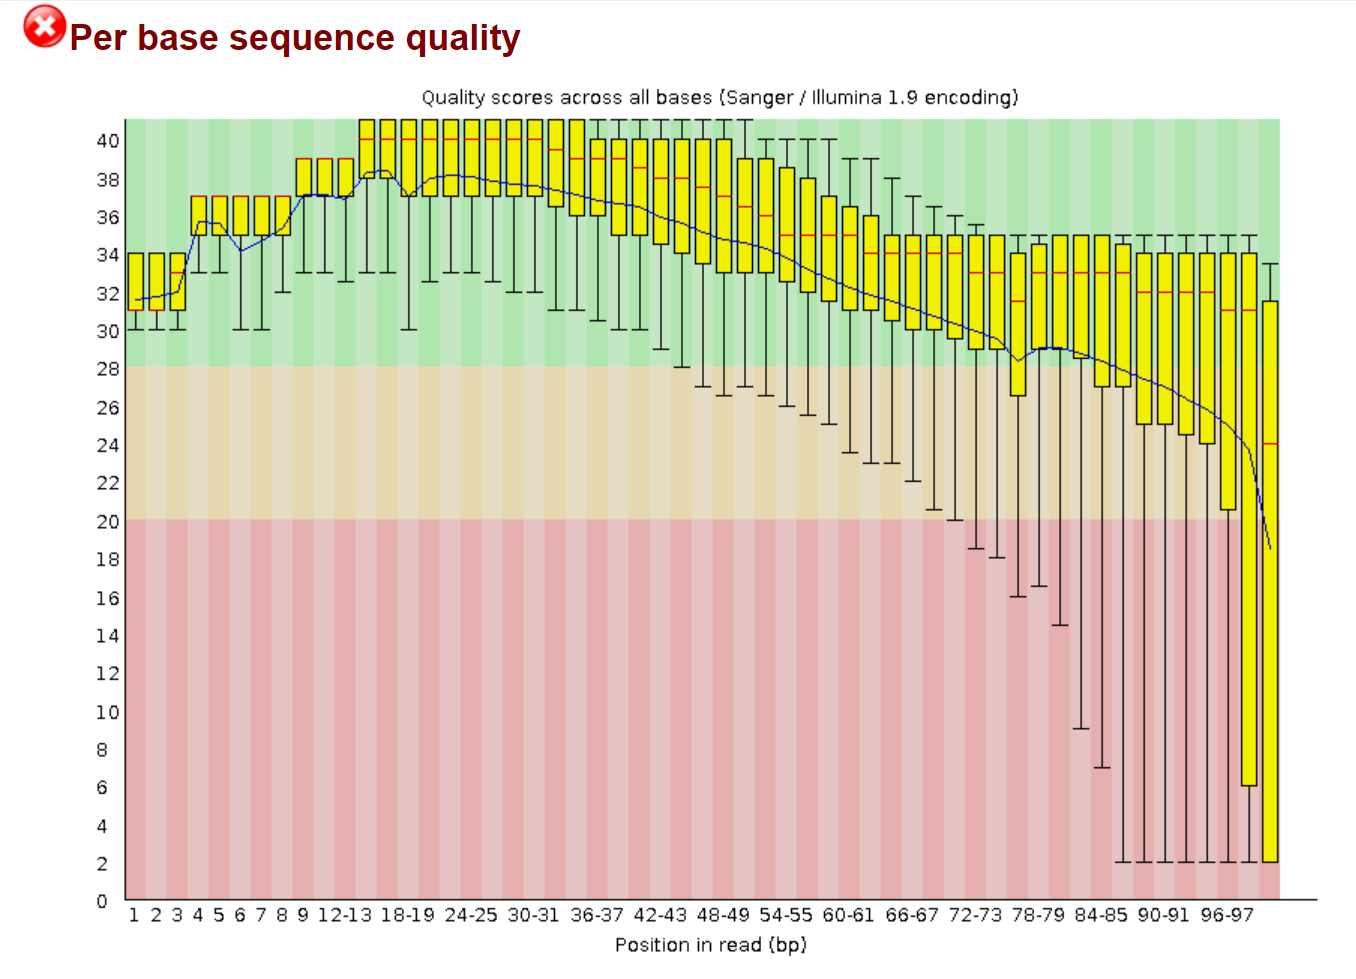

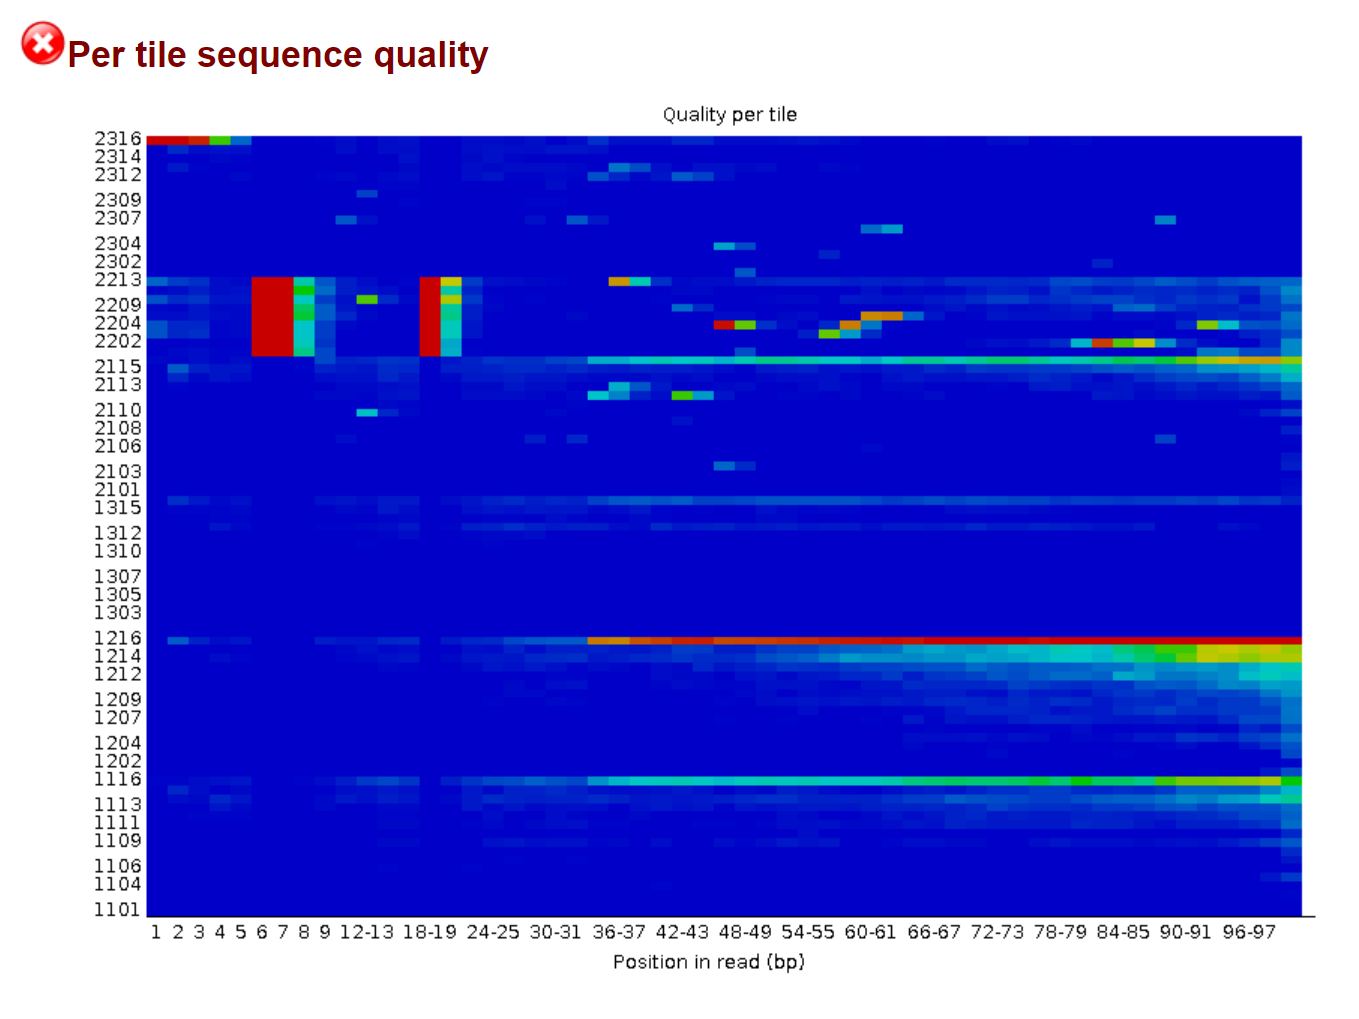

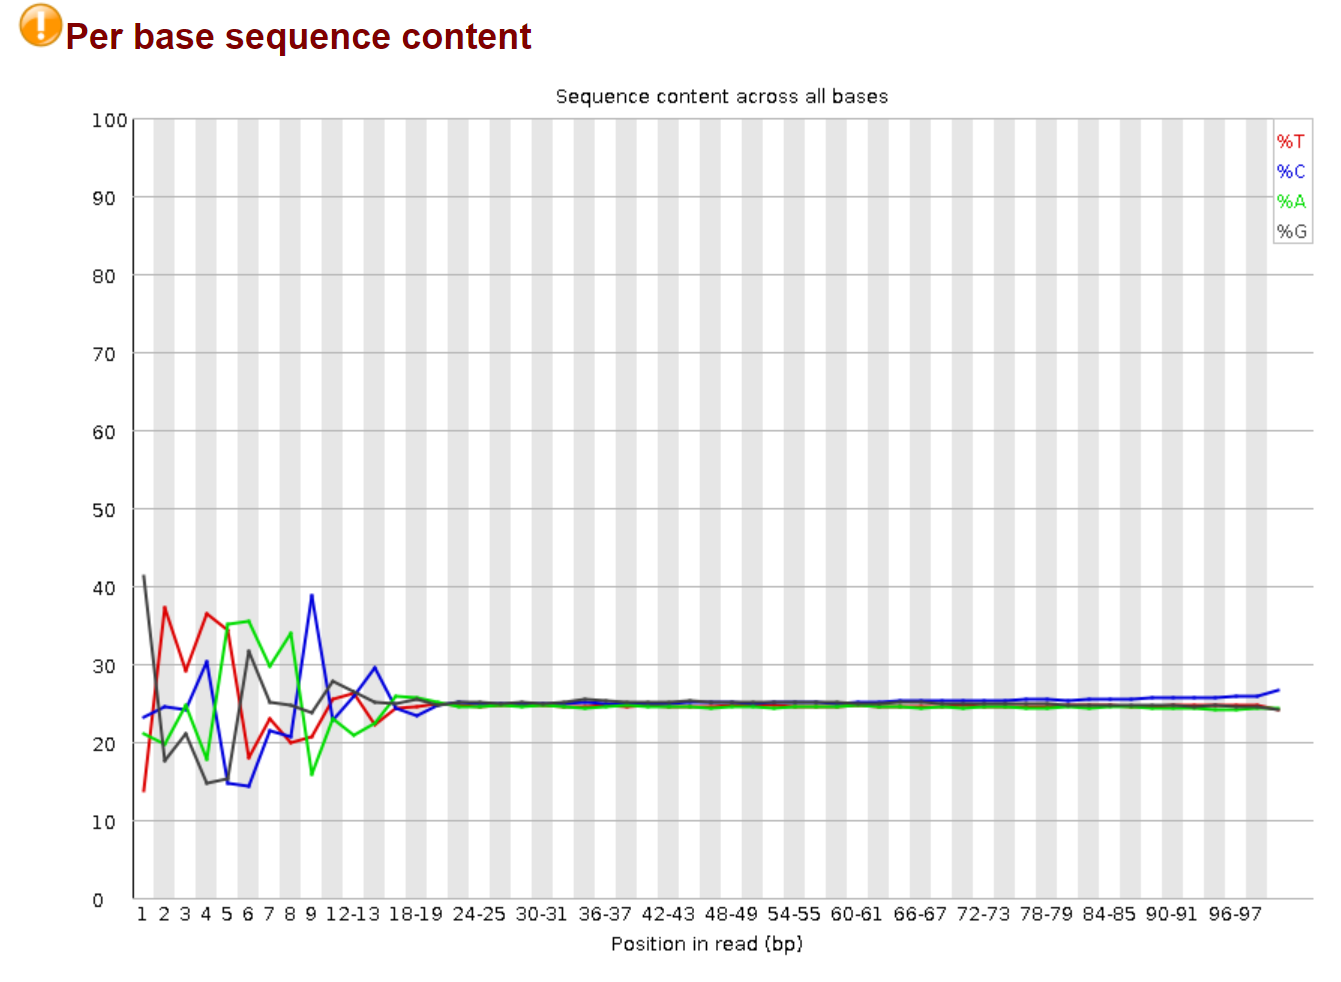

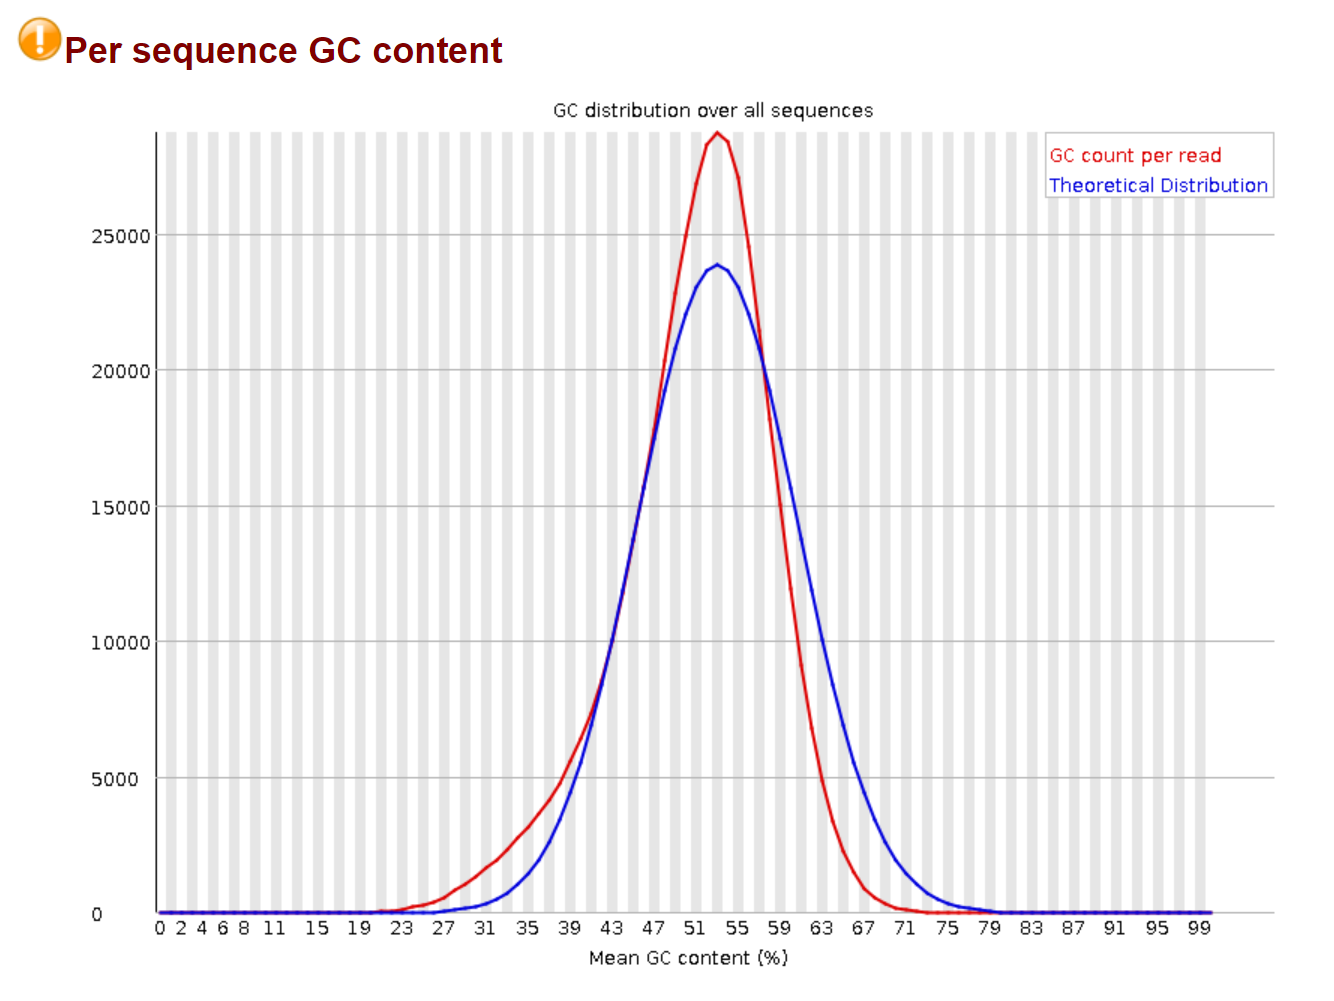

`fastqc data/e_coli_k12_reads_reverse.fastq -o data/` 

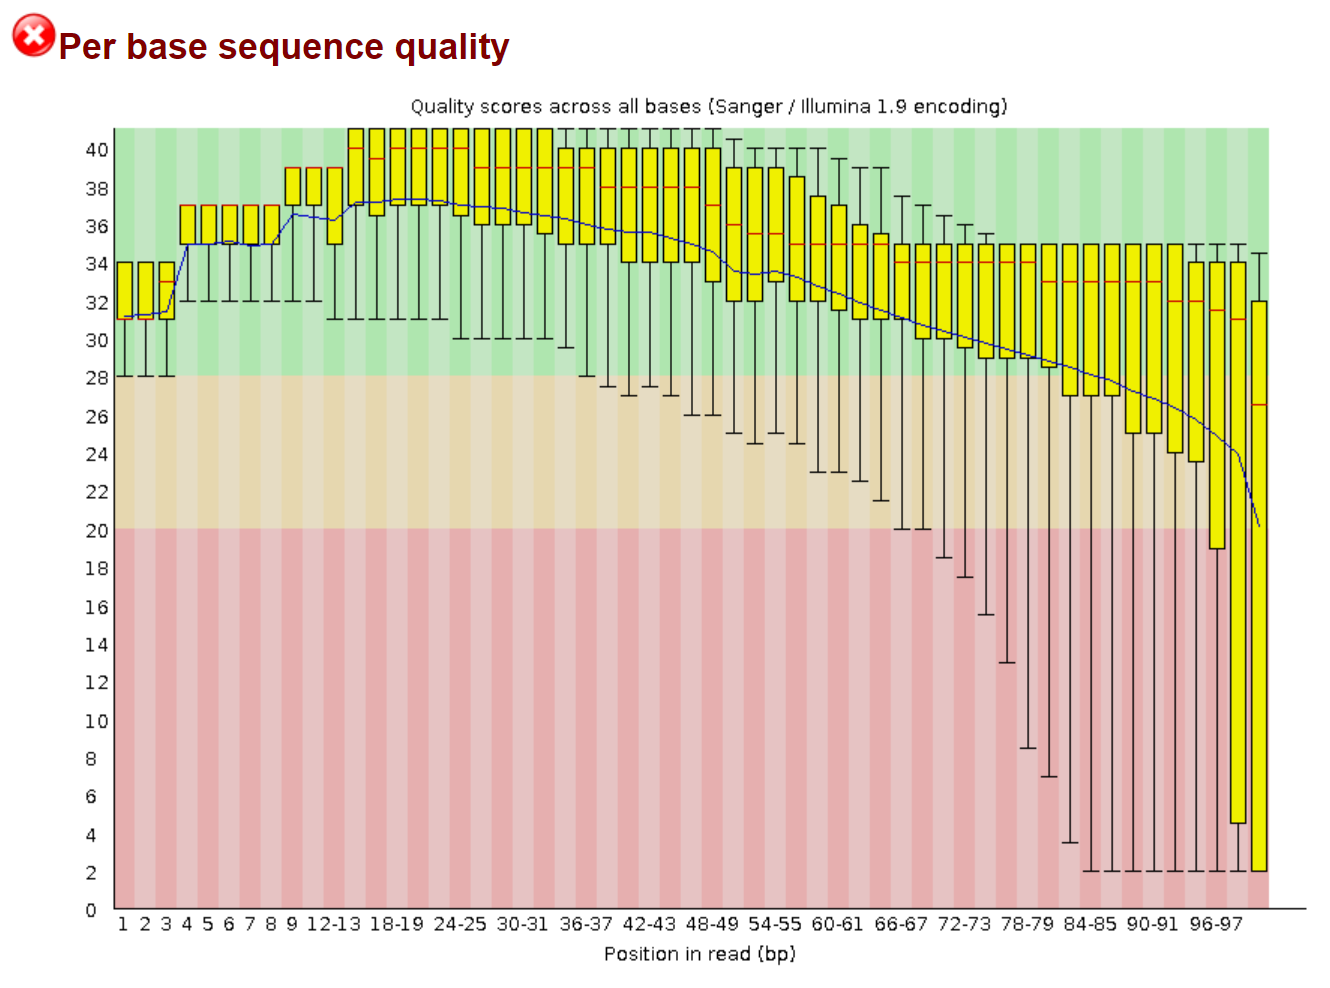

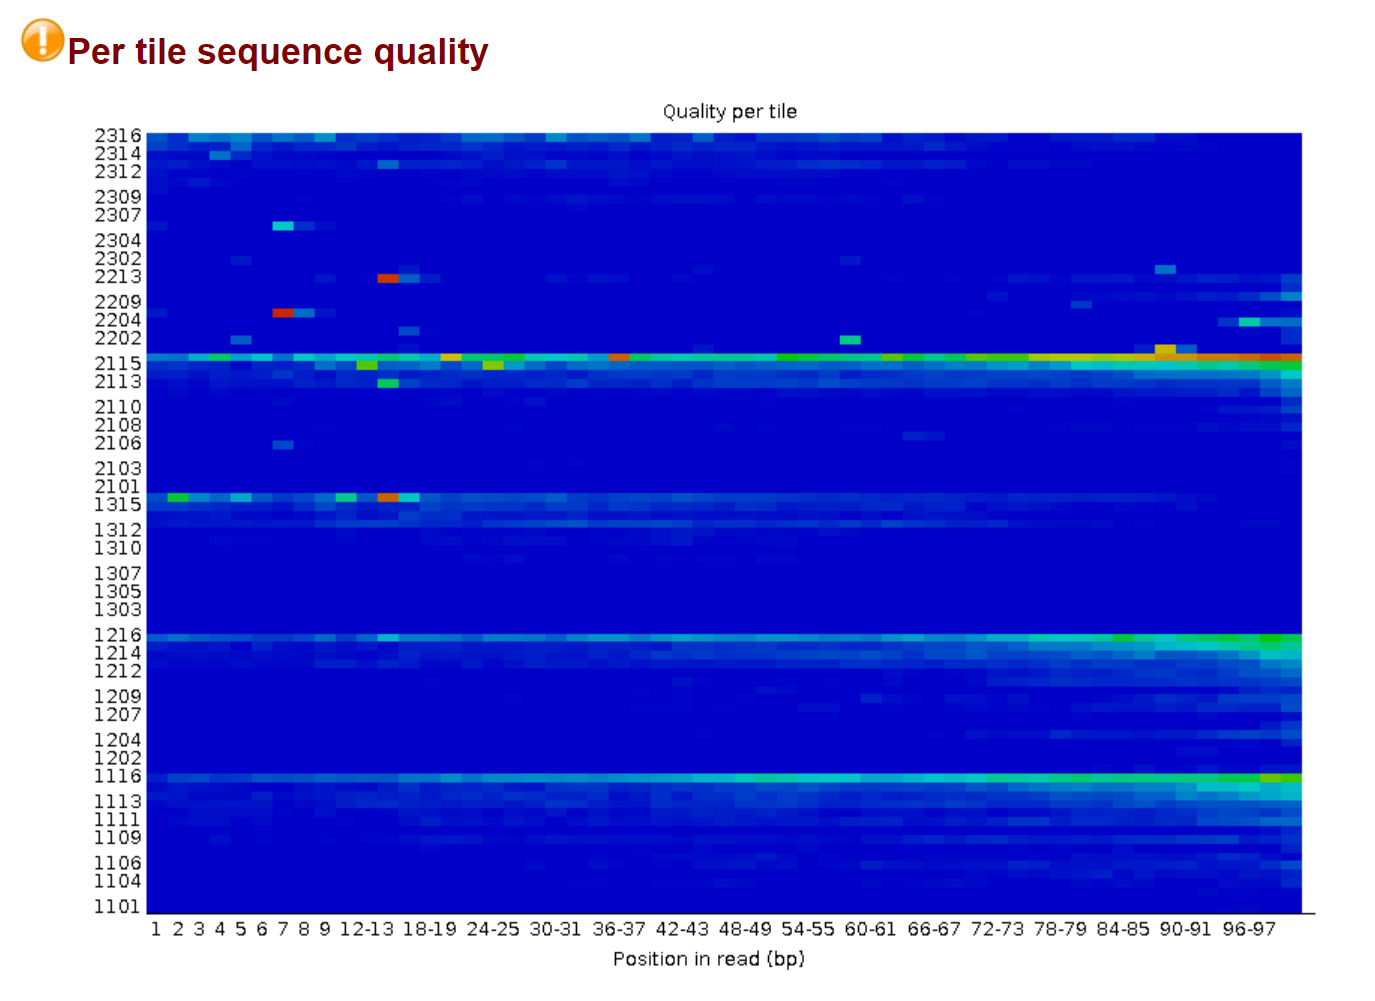

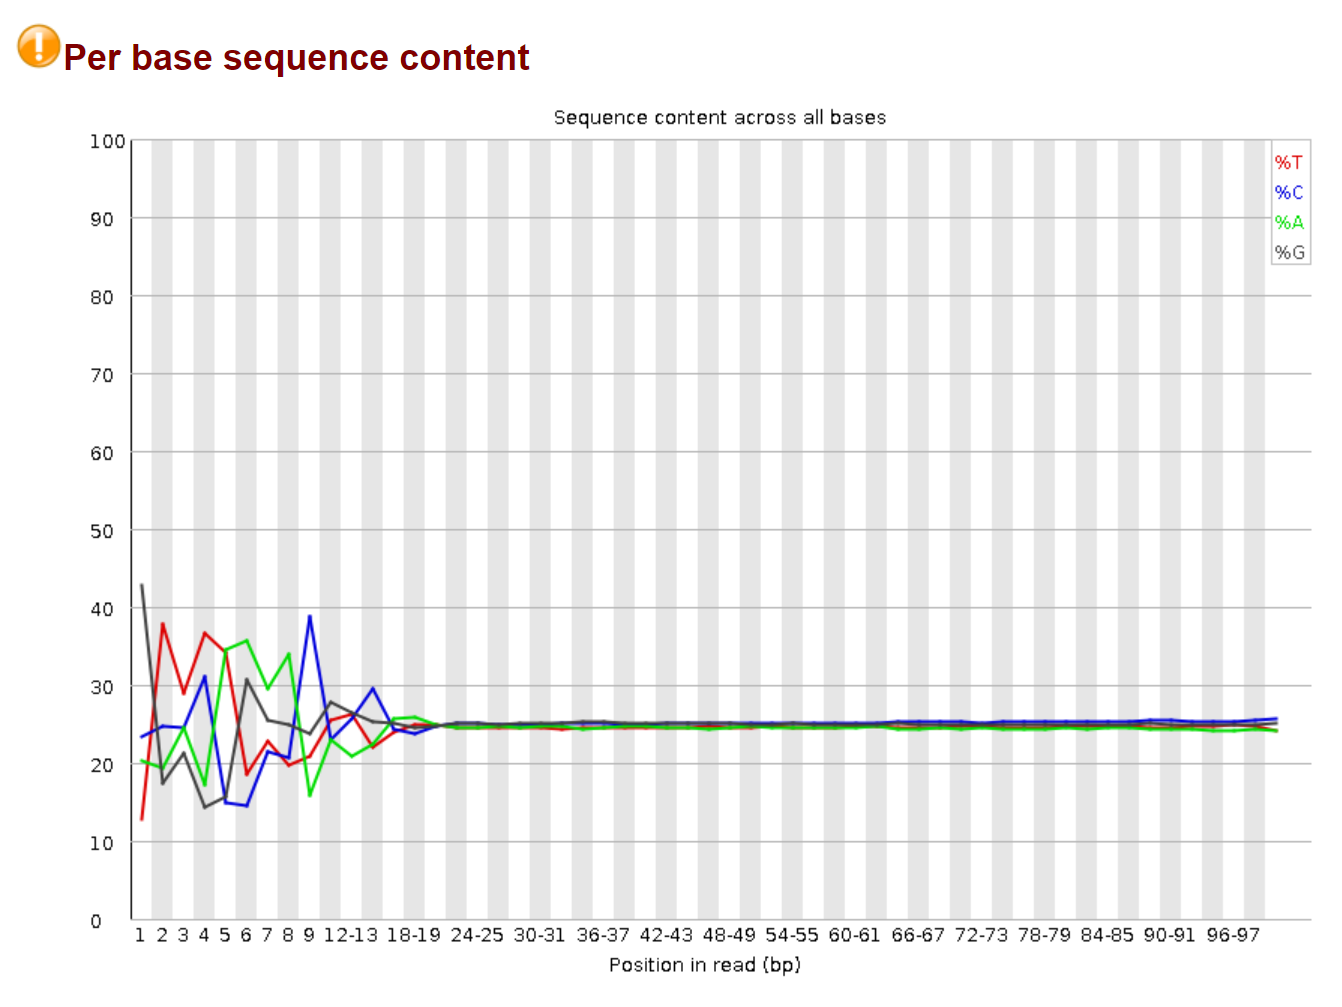

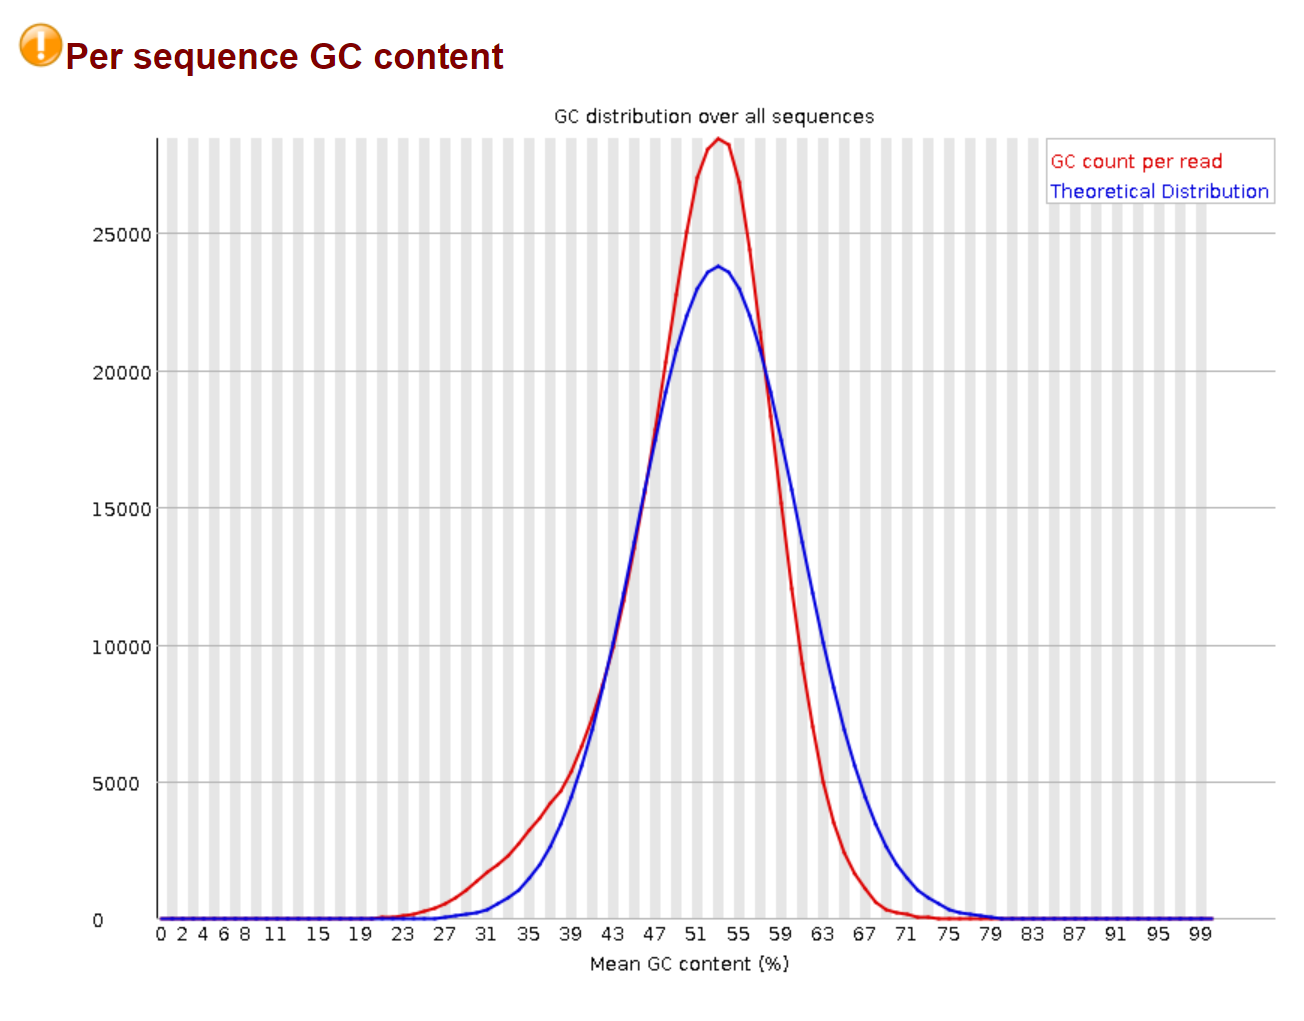

`trimmomatic PE -phred33 data/e_coli_k12_reads_forward.fastq data/e_coli_k12_reads_reverse.fastq data/e_coli_k12_reads_output_forward_paired.fastq data/e_coli_k12_reads_output_forward_unpaired.fastq data/e_coli_k12_reads_output_reverse_paired.fastq data/e_coli_k12_reads_output_reverse_unpaired.fastq LEADING:20 TRAILING:20 SLIDINGWINDOW:10:20 MINLEN:20` \
- `-phred33`: Indicates that the quality scores are in Phred+33 format. \
- `LEADING:20`: Removes bases from the start of each read if the quality is below 20. \
- `TRAILING:20`: Removes bases from the end of each read if the quality is below 20. \
- `SLIDINGWINDOW:10:20`: Performs a sliding window trimming with a window size of 10 and trims when the average quality within the window falls below 20. \
- `MINLEN:20`: Drops reads below a length of 20. 

Input Read Pairs: 455876 Both Surviving: 446259 (97.89%) Forward Only Surviving: 9216 (2.02%) Reverse Only Surviving: 273 (0.06%) Dropped: 128 (0.03%)

`fastqc data/e_coli_k12_reads_output_forward_paired.fastq -o data/` \
`fastqc data/e_coli_k12_reads_output_reverse_paired.fastq -o data/`

## 3. Aligning sequences to reference

- index reference \
`bwa index data/GCF_000005845.2_ASM584v2_genomic_reference.fna.gz` \
- align reads \
`bwa mem data/GCF_000005845.2_ASM584v2_genomic_reference.fna.gz data/e_coli_k12_reads_output_forward_paired.fastq data/e_coli_k12_reads_output_reverse_paired.fastq > data/e_coli_k12_alignment.sam` \
- compress .sam \
`samtools view -S -b data/e_coli_k12_alignment.sam > data/e_coli_k12_alignment.bam` \
- statistics \
`samtools flagstat data/e_coli_k12_alignment.bam` \
892776 + 0 in total (QC-passed reads + QC-failed reads)
892518 + 0 primary
0 + 0 secondary
258 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
891649 + 0 mapped (99.87% : N/A)
891391 + 0 primary mapped (99.87% : N/A)
892518 + 0 paired in sequencing
446259 + 0 read1
446259 + 0 read2
888554 + 0 properly paired (99.56% : N/A)
890412 + 0 with itself and mate mapped
979 + 0 singletons (0.11% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

- sort .bam \
`samtools sort data/e_coli_k12_alignment.bam -o data/e_coli_k12_alignment_sorted.bam` \
- index sorted .bam \
`samtools index data/e_coli_k12_alignment_sorted.bam`

## 4. Variant calling

The goal now is to go through our data, and for each position in the reference genome, see how many reads have a mutation at the same position - we want to distinguish actual mutations from the sequencing errors. The solution is to make an intermediate file type called an mpileup, because it goes through each position and “piles up” the reads, tabulating the number of bases that match or don’t match the reference. 

- Mpileup requires a sorted, indexed bam file (aparently I need unzipped file and on-the-fly unzipping doesn't work) \
`bgzip -d data/GCF_000005845.2_ASM584v2_genomic_reference.fna.gz`
`samtools mpileup -f data/GCF_000005845.2_ASM584v2_genomic_reference.fna data/e_coli_k12_alignment_sorted.bam > data/e_coli_k12_alignment_sorted.mpileup` \
- VarScan variant calling (paste path to VarScan) \
`java -jar /mnt/d/Bioinformatics/VarScan/VarScan.v2.3.9.jar mpileup2snp data/e_coli_k12_alignment_sorted.mpileup --min-var-freq 0.50 --variants --output-vcf 1 > data/e_coli_k12_alignment_sorted_VarScan_results.vcf`


## 5. Variant effect prediction

Find out where these mutations are and whether they actually change any proteins in the host (mutations can also occur outside of genes in non-coding regions, or they can be synonymous, where they substitute a codon for the same amino acid). 



## 6. Automatic SNP annotation

It is really easy to make mistakes on the previous step. For each mutation you need to pick up the correct strand - sense or antisense, or "+" and "-". (Note that you can switch between strands in IGV using "reverse complement" option). Then, you need to pick the correct reading frame (based on annotation), mind the direction and manually check if there is a missense or nonsense mutation.

- get gbff reference \
`wget -O data/GCF_000005845.2_ASM584v2_genomic_reference.gbff.gz https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.gbff.gz`

Step 1. Create database
    - create empty text file snpEff.config, and add there just one string: \
    k12.genome : ecoli_K12 \
    `echo "k12.genome : ecoli_K12" > data/snpeff.config` \
    - create folder for the database \
    `mkdir -p data/k12` \
    - Put there your .gbk file (unzip and rename to genes.gbk) \
    `gunzip data/GCF_000005845.2_ASM584v2_genomic_reference.gbff.gz` \
    `cp data/GCF_000005845.2_ASM584v2_genomic_reference.gbff data/k12/genes.gbk` \
    - create database \
    `snpEff build -genbank -v k12`
00:00:00 SnpEff version SnpEff 5.2 (build 2023-09-29 06:17), by Pablo Cingolani
00:00:00 Command: 'build'
00:00:00 Building database for 'k12'
00:00:00 Reading configuration file 'snpEff.config'. Genome: 'k12'
00:00:00 Reading config file: /app/data/snpEff.config
00:00:00 Reading config file: /root/anaconda3/share/snpeff-5.2-0/snpEff.config
java.lang.RuntimeException: Property: 'k12.genome' not found
        at org.snpeff.interval.Genome.<init>(Genome.java:103)
        at org.snpeff.snpEffect.Config.readConfig(Config.java:757)
        at org.snpeff.snpEffect.Config.init(Config.java:532)
        at org.snpeff.snpEffect.Config.<init>(Config.java:119)
        at org.snpeff.SnpEff.loadConfig(SnpEff.java:449)
        at org.snpeff.snpEffect.commandLine.SnpEffCmdBuild.run(SnpEffCmdBuild.java:409)
        at org.snpeff.SnpEff.run(SnpEff.java:1173)
        at org.snpeff.SnpEff.main(SnpEff.java:163)
00:00:00 Logging
00:00:01 Done.

:(

